In [8]:
import pickle
import os

###Mount data

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
#!ls drive/'My Drive'

In [4]:
drive_path = 'drive/My Drive/Project22'

In [5]:
print(os.getcwd())
#if not os.getcwd() == '/content/drive/My Drive/Project22':
os.chdir(drive_path)
#  os.getcwd()

/content


In [4]:
pip install mido

In [13]:
# GLOBALS

SEQ_LENGTH = 256
TARGET_LENGTH = 1
NUM_CLASSES = 135




### Dataloader


In [6]:
import numpy as np
import pandas as pd
import os
from math import floor
from midi_conversion import convert_midi_to_numpy, convert_matrix_to_word_seq, convert_to_number_seq
from torch.utils import data
import random
from time import time

#from PIL import Image, ImageOps
#from skimage.io import imread
#from skimage.transform import resize
#from sklearn.model_selection import StratifiedShuffleSplit
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)

In [ ]:
    """class Dataset(data.Dataset): 
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        # Return the size of the dataset
        return len(self.targets)

    def __getitem__(self, index):
        # Retrieve inputs and targets at the given index
        X = self.inputs[index]
        y = self.targets[index]
        return X, y
"""

'class Dataset(data.Dataset): \ndef __init__(self, inputs, targets):\n    self.inputs = inputs\n    self.targets = targets\n\ndef __len__(self):\n    # Return the size of the dataset\n    return len(self.targets)\n\ndef __getitem__(self, index):\n    # Retrieve inputs and targets at the given index\n    X = self.inputs[index]\n    y = self.targets[index]\n    return X, y\n'

In [9]:
class load_data():
    # data_train, data_test and le are public
    def __init__(self, print_status = False, ticks_per_beat = 12):
        track_paths = self._generate_paths()
        self.ticks_per_beat = ticks_per_beat
        self.print_status = print_status
        self._load(track_paths)

    def _generate_paths(self):
        #allowed_folders = ["2004","2006","2008","2009","2011","2013","2014","2015","2017","2018"]
        allowed_folders = ["2004","2006","2008","2009"]
        paths = []
        maestro_dir = "./maestro-v2.0.0/"
        for maestro_folder in os.listdir(maestro_dir):
            if maestro_folder in allowed_folders:
                for track_path in os.listdir(maestro_dir + maestro_folder):
                    paths.append(maestro_dir + maestro_folder +
                                 "/" + track_path)
                  
        return paths

    def _load(self, track_paths):
        test_fraction = 0.1
        self.train_data = []
        self.test_data = []
        # debug
        t0 = time()
        load_times = []
        tracks_done = 0

        # the real dataloader
        for path in track_paths:
            t1 = time() #debug
            track = convert_midi_to_numpy(path, ticks_per_beat = self.ticks_per_beat) #convert to vector representation
            track = convert_matrix_to_word_seq(track) #convert to word seq
            track = convert_to_number_seq(track) #convert to number representation
            track_np = np.array(track) #convert to numpy
            if random.random() > test_fraction: self.train_data.append(track_np) # add to train
            else: self.test_data.append(track_np) # add to test
            #debug
            tracks_done += 1
            t2 = time()
            load_time = t2-t1
            load_times.append(load_time)
            tracks_left = len(track_paths) - tracks_done
            load_time_avr = sum(load_times)/len(load_times)
            if self.print_status: print(path[-20:],"took",str(load_time)[:4],"s,",tracks_done,"out of",len(track_paths),": time left", str((tracks_left*load_time_avr)/60)[:4],"minutes")
        
        """
        #test dataloader
        for i in range(250):
            track_length = 1000
            note = random.randint(0,128)
            track = np.zeros((track_length,129))
            for e in range(track_length): #line
                track[e][note] = 1
            train_data.append(track)
            test_data.append(track)
        """

        print("train:",len(self.train_data))
        print("test:",len(self.test_data))

        #cut to 1024 pieces (snack pieces)
        #self.train_cut = self._chop_data(self.train_uncut)
        #self.test = self._chop_data(self.test_uncut)
        #self.train_targets = self._chop_data(self.train_uncut_shifted)
        #self.test_targets = self._chop_data(self.test_uncut_shifted)
        #self.train = Dataset(self.train_cut, self.train_targets)

    def generate_cut_data(self, cut_length = 128):
        self.cut_length = cut_length
        #chop and generate targets
        train_data_cut, train_data_cut_targets = self._chop_data(self.train_data)
        test_data_cut, test_data_cut_targets = self._chop_data(self.test_data)

        #convert to numpy, rename data and add extra pseduo dimension
        self.train_cut = np.expand_dims(np.array(train_data_cut),2)
        self.train_cut_targets = np.array(train_data_cut_targets)
        self.test_cut = np.expand_dims(np.array(test_data_cut),2)
        self.test_cut_targets = np.array(test_data_cut_targets)

    def _shift_data(self,data, n=1):
        data = np.roll(data, -n, axis = 0)
        data[-1] = 0 #makes the very last number 0 to keep the correct size
        return data

    def _chop_data(self, uncut_data):
        seq_length = self.cut_length
        all_tracks_cut = []
        all_tracks_cut_targets = []
        for track in uncut_data:
            track_pieces_length = floor(len(track)/seq_length)
            leftover_length = len(track)%seq_length
            #cut track
            for i in range(track_pieces_length):
                if (i+1)*seq_length+TARGET_LENGTH > len(track): break #if its too short for creating target, stop
                all_tracks_cut.append(track[i*seq_length:(i+1)*seq_length])
                all_tracks_cut_targets.append(track[(i+1)*seq_length : (i+1)*seq_length+TARGET_LENGTH]) #first part of next cut
            #and the tail. adds trailing zeroes to make up for missing length 
            #ACUTALLY WHATEVER THE TAIL ITS JUST ZEROES EITHER WAY ---
            #leftover = track[seq_length*track_pieces_length:] + [0 for _ in range(track_pieces_length - leftover_length)]
            #cut_track.append(leftover)

        return all_tracks_cut, all_tracks_cut_targets
            


In [10]:
class batch_generator():
    def __init__(self, data, batch_size=64,
                 num_iterations=5e3, num_features=1, seed=42, val_size=0.1):
        self._train = data.train_cut
        self._train_targets = data.train_cut_targets
        self._test = data.test_cut #TODO WE DON'T USE THIS YET
        self._test_targets = data.test_cut_targets #TODO WE DON'T USE THIS YET

        self._batch_size = batch_size
        self._seq_length = SEQ_LENGTH
        self._num_iterations = num_iterations
        self._num_features = num_features
        self._seed = seed
        self._val_size = val_size
        self._valid_split()

    def _valid_split(self):
        p = self._val_size
        val_filter = [True if p < random.random() else False for _ in range(len(self._train))] #some filter to choose valid from
        train_filter = [not val for val in val_filter]
        #while True: a = 0 #nice debug break
        self._idcs_valid = np.arange(len(self._train))[val_filter]
        self._idcs_train = np.arange(len(self._train))[train_filter]

    def _shuffle_train(self):
        np.random.shuffle(self._idcs_train)

    def _batch_init(self, purpose):
        assert purpose in ['train', 'valid', 'test']

        batch_holder = dict()

        batch_holder['inputs'] = np.zeros(
            (self._batch_size, self._seq_length, 1), dtype="float32")
        batch_holder['targets'] = np.zeros(
            (self._batch_size, TARGET_LENGTH), dtype="float32")
        return batch_holder

    def gen_valid(self):
        batch = self._batch_init(purpose='valid')
        i = 0
        for idx in self._idcs_valid:
            batch['inputs'][i] = self._train[idx]
            batch['targets'][i] = self._train_targets[idx]
            i += 1
            if i >= self._batch_size:
                yield batch, i
                batch = self._batch_init(purpose='valid')
                i = 0
        #if i != 0:
        #    batch = batch[:i]
        #    yield batch, i

    def gen_test(self): #TODO THIS IS PROBABLY BROKEN FOR NOW
        batch = self._batch_init(purpose='test')
        i = 0
        for idx in range(len(self._test)):
            batch[i] = self._test[idx]
            i += 1
            if i >= self._batch_size:
                yield batch, i
                batch = self._batch_init(purpose='test')
                i = 0
        if i != 0:
            yield batch, i

    def gen_train(self):
        batch = self._batch_init(purpose='train')
        iteration = 0
        i = 0
        while True:
            # shuffling all batches between batches. Shuffles idcs so it keeps the targets
            self._shuffle_train()
            for idx in self._idcs_train:
                # extract data from dict
                batch['inputs'][i] = self._train[idx]
                batch['targets'][i] = self._train_targets[idx]
                i += 1
                if i >= self._batch_size:
                    yield batch
                    batch = self._batch_init(purpose='train')
                    i = 0
                    iteration += 1
                    if iteration >= self._num_iterations:
                        break

### Load Data

In [ ]:
data = load_data(print_status = True) # UNCOMMENT FOR DATA LOADER

_R1_2008_wav--1.midi took 1.52 s, 1 out of 519 : time left 13.1 minutes
_R1_2008_wav--3.midi took 2.94 s, 2 out of 519 : time left 19.2 minutes
_R1_2008_wav--4.midi took 1.78 s, 3 out of 519 : time left 17.9 minutes
_R1_2008_wav--2.midi took 2.28 s, 4 out of 519 : time left 18.3 minutes
_R2_2008_wav--1.midi took 1.09 s, 5 out of 519 : time left 16.5 minutes
_R1_2008_wav--2.midi took 1.16 s, 6 out of 519 : time left 15.3 minutes
_R2_2008_wav--4.midi took 0.58 s, 7 out of 519 : time left 13.8 minutes
_R1_2008_wav--5.midi took 1.26 s, 8 out of 519 : time left 13.4 minutes
_R2_2008_wav--3.midi took 1.00 s, 9 out of 519 : time left 12.8 minutes
_R1_2008_wav--3.midi took 0.48 s, 10 out of 519 : time left 11.9 minutes
_R1_2008_wav--2.midi took 0.91 s, 11 out of 519 : time left 11.5 minutes
_R1_2008_wav--1.midi took 0.89 s, 12 out of 519 : time left 11.2 minutes
_R3_2008_wav--2.midi took 1.38 s, 13 out of 519 : time left 11.2 minutes
_R1_2008_wav--1.midi took 1.35 s, 14 out of 519 : time left 

In [ ]:
#data.train_data[0][:10] #DEBUG

In [20]:
# CUT DATA
data.generate_cut_data(SEQ_LENGTH)

In [ ]:
#i = 4124
#print(data.train_cut[i])
#print(data.train_cut_targets[i])

In [ ]:
# DATA DEBUG
#data.train_data = [list(range(457)) for _ in range(10000)]

In [19]:
# PICKLE STUFF
# Dump the data into a pickle file
"""
with open('data.pickle_half_tracks_cut', 'wb') as f:
  pickle.dump(data, f)

"""

with open('data.pickle_half_tracks_cut', 'rb') as f:
    data = pickle.load(f)



In [ ]:
#Some debugging stuff
#data.train_cut[0]

In [ ]:
"""for o in range(257,300):
    n = np.count_nonzero(data.train_cut == o)
    s = data.train_cut.size
    print((n/s)*100,"% is ",o," i.e. wait")"""

'for o in range(257,300):\n    n = np.count_nonzero(data.train_cut == o)\n    s = data.train_cut.size\n    print((n/s)*100,"% is ",o," i.e. wait")'

In [30]:
np.count_nonzero(data.train_cut > 120)/data.train_cut.size*100 # % percents are wait

37.095672076448864

In [ ]:
#data.train_data = old_train_data

In [ ]:
# DISTRUBUTE WAITS OVER RANGE
"""for i, track in enumerate(data.train_data):
    c = 0
    for e, num in enumerate(track):
        if num > 258: # is wait
            data.train_data[i][e] = random.randint(259,300)
"""

'for i, track in enumerate(data.train_data):\n    c = 0\n    for e, num in enumerate(track):\n        if num > 258: # is wait\n            data.train_data[i][e] = random.randint(259,300)\n'

In [ ]:

np.unique(data.train_cut)

data.train_cut.shape


(64154, 128, 1)

In [ ]:
np.max(data.train_cut)

457

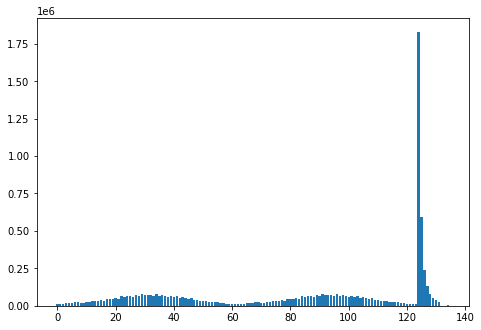

In [29]:
data_distr = np.bincount(data.train_cut.reshape((-1)))
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = list(range(len(data_distr)))
y = data_distr
ax.bar(x,y)
axes = plt.gca()
#axes.set_ylim([0,100000])
#axes.set_xlim([0,120])
plt.show()

In [ ]:
# and its corresponding target
#plot_midi(data.train_cut_targets[10][:],seq_length = TARGET_LENGTH)
#%debug

In [ ]:
#mone = np.full((151337, 1), 1)
#data.train_cut = np.subtract(data.train_cut, mone)

In [ ]:
#np.unique(data.train_cut_targets)

### Network

In [ ]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d, ReLU
from torch.nn.functional import relu, elu, relu6, tanh, softmax

lstm_hidden = 50
seq_length = SEQ_LENGTH
OUT_CLASSES = 135
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        self.lstm_1 = nn.LSTM(input_size=1,
                              hidden_size=lstm_hidden,
                              num_layers=1,
                              bidirectional=False,
                              batch_first = True)


        self.l_hidden = Linear(in_features = lstm_hidden*seq_length,
                                    out_features = OUT_CLASSES,
                                    bias=False)
        """

        self.l_hidden = Linear(in_features = seq_length,
                                    out_features = SEQ_LENGTH*50,
                                    bias=False)
    
        self.l_hidden2 = Linear(in_features = SEQ_LENGTH*50,
                                    out_features = NUM_CLASSES,
                                    bias=False)
        """
        

        self.dropout = Dropout(0.1)
        


    def forward(self, inp):
        
        #features = []
        out = {}
        

        #x, (h, c) = self.lstm_1(x)
        #x,_ = self.lstm_1(inp)

        #print("x",x.shape)
        #print("h",h)
        #print("c",c)
        #print("----")

        #features.append(x)
        # Final concatenated data processing
        #features_final = torch.cat(features, dim=1)


        #print("x0",x)

        #x = torch.reshape(x,(-1,3))
        #x = torch.transpose(x,1,0)

        x, _ = self.lstm_1(inp)
        #x = inp
        x = torch.reshape(x,(x.shape[0],-1))
        x = self.dropout(x)
        x = torch.sigmoid(self.l_hidden(x))
        #x = torch.sigmoid(self.l_hidden2(x))
        out['out'] = np.squeeze(x)

        return out

use_cuda = torch.cuda.is_available() #TODO ALLOW AGAIN
net = Net()
if use_cuda:
    net.cuda()

print(net)


Net(
  (lstm_1): LSTM(1, 50, batch_first=True)
  (l_hidden): Linear(in_features=12800, out_features=135, bias=False)
  (dropout): Dropout(p=0.1, inplace=False)
)


In [ ]:
# a small sanity check
#%debug

inp = torch.randn(500, SEQ_LENGTH, 1).cuda()

outp,hidden = net(inp)
outp,hidden = net(inp)

for key in outp:
    print(key,outp[key].shape)
    #print(outp[key][0][1])


out torch.Size([500, 135])


### Training loop

In [ ]:
from numpy.lib.npyio import load
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d, ReLU
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
import matplotlib.pyplot as plt
from IPython.display import clear_output
from math import log

In [ ]:
VALIDATION_SIZE = 0.1  # 0.1 is ~ 100 samples for validation
max_iter = 2000
log_every = 100
eval_every = 100
batch_size = 500

net = Net()
if use_cuda:
    net.cuda()

def simple_crit(inputs,targets):
    b = torch.abs(torch.subtract(inputs,targets)-0.001)
    a = -torch.log(b)
    return torch.mean(a)

LEARNING_RATE = 0.0001
#criterion = nn.BCEWithLogitsLoss(reduction = "mean")

#normie weights
#loss_weights = torch.zeros(135)
#loss_weights[0:62*2] = 1
#loss_weights[62*2:] = 0.01
#loss_weights = loss_weights.cuda()

#distr weights
data_distr = np.bincount(data.train_cut.reshape((-1)))
ddd = torch.FloatTensor([1/(data_distr[i]*0.001) for i in range(135)]).cuda()
criterion = nn.CrossEntropyLoss(ddd)
#criterion = simple_criterion
#criterion = simple_crit
#criterion = nn.MSELoss()

def accuracy(ys, ts):
    ys = torch.argmax(ys, dim=1)
    correct_prediction = torch.eq(ys, ts)
    return torch.mean(correct_prediction.float())

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)#, weight_decay=1e-5)

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = batch_generator(data,
                                batch_size=batch_size,
                                num_iterations=max_iter,
                                seed=42,
                                val_size=VALIDATION_SIZE)


def get_input(batch):
    return get_variable(Variable(torch.from_numpy(batch)))

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()


# Train network
net.train()
train_idx = 0

h = torch.randn(1, 500, lstm_hidden).cuda()
c = torch.randn(1, 500, lstm_hidden).cuda()
hidden = (h,c)

for i, batch_train in enumerate(batch_gen.gen_train()):

    if i % eval_every == 0:
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0

        #batches = batch_gen.gen_valid()
        for batch_valid, num in batch_gen.gen_valid():
            output,_ = net(get_input(batch_valid['inputs']))
            #print("hej")
            #print(output['out'])
            #print(criterion(output['out'], get_input(batch_valid['targets'])))
            val_losses += criterion(output['out'], get_input(np.squeeze(batch_valid['targets'])).long()) * num
            val_accs += accuracy(output['out'], get_input(np.squeeze(batch_valid['targets']))) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
   
        net.train()

    # Train network
    output,_ = net(get_input(batch_train['inputs']))

    #labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    #validation_batch = get_variable(torch.transpose(torch.from_numpy(batch_train).long(), 0, 1))
    #validation_batch = get_variable(torch.transpose(torch.from_numpy(batch_train).long(), 0, 1))
    batch_loss = criterion(output['out'], get_input(np.squeeze(batch_train['targets'])).long())
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], get_input(batch_train['targets'])))))

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(18, 6))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs,
                  label='valid_accs: ' + str(valid_accs[-1]))
        plt.legend()
        plt.show()
        clear_output(wait=True)
   
    if max_iter < i:
        break


#val = torch.max([])


RuntimeError: ignored

In [ ]:
%debug

In [ ]:
i = 2
print(np.squeeze(batch_train["inputs"][i]))
np.squeeze(batch_train["targets"][i])

[ 73. 127.  26. 127.  88. 125.  18. 125.  23. 124.  80. 124.  85.  26.
  40. 125.  88. 124.  17. 126.  79. 124.  26. 125.  88. 124.  18. 125.
  23. 124.  80. 124.  85.  26.  38. 126.  97. 104. 124.  17.  88. 124.
  30. 125.  26. 125.  79. 125.  18. 124.  23.  88. 124.  37. 125.  80.
  26. 124. 102. 124.  17.  85. 100. 126.  88. 124.  79. 124.  26. 124.
  35. 125.  18. 124.  23.  88. 124.  85. 124.  26. 124.  80. 124.  11.
  88.  99. 128.  97.  38. 126.  73.  26. 125.  88. 126.  16. 125.  23.
 124.  85. 125.  26. 124.  33. 124.  78.  88. 126.  15. 125.  77. 125.
  26. 124.  88. 125.  16.  23.  92. 125.  32. 125.  26. 124.  78.  85.
  88. 125.]


array(15., dtype=float32)

In [ ]:
"""
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
print(input)
print(target)
#output.backward()
loss = nn.CrossEntropyLoss()

input = torch.from_numpy(np.array([[1.0,1.0,0.0]]))
target = torch.from_numpy(np.array([1]))
loss(input, target)
"""

'\ninput = torch.randn(3, 5, requires_grad=True)\ntarget = torch.empty(3, dtype=torch.long).random_(5)\nprint(input)\nprint(target)\n#output.backward()\nloss = nn.CrossEntropyLoss()\n\ninput = torch.from_numpy(np.array([[1.0,1.0,0.0]]))\ntarget = torch.from_numpy(np.array([1]))\nloss(input, target)\n'

In [ ]:
#notes_np = midi_conversion.convert_midi_to_numpy("maestro-v2.0.0/2008/MIDI-Unprocessed_04_R1_2008_01-04_ORIG_MID--AUDIO_04_R1_2008_wav--4.midi")

In [ ]:
from midi_plotter import plot_midi, plot_num_seq

In [ ]:
"""i = 4
inp = batch_train['inputs'][i]
tar = batch_train['targets'][i]"""

In [ ]:
#plot_midi(inp,show_plot=True, seq_length=25)

In [ ]:
#plot_midi(tar,show_plot=True, seq_length=TARGET_LENGTH)

In [ ]:
import midi_conversion

In [ ]:
r = random.randint(0,99)
print(r)
#inp_np = np.array(batch_train['inputs'])[r] # +np.full((128,1),5) #only one batch
inp_np = batch_valid['inputs'][r] # +np.full((128,1),5) #only one batch
print(np.squeeze(inp_np))
net.eval()
all_removed = []
for i in range(1000):
    #inp = torch.from_numpy(np.array([inp_np])).float().cuda()
    inp = get_input(np.array([inp_np]))
    outp = net(inp)['out']
    outp = outp.cpu().detach()
    pred = torch.argmax(outp).numpy()
    #print("pred",pred)
    all_removed.append(inp_np[0])
    inp_np = np.roll(inp_np,-1,0)
    inp_np[-1] = [pred]

np.squeeze(inp_np)

98
[124.  20. 130.  26. 124.  21. 125.  82. 127.  23. 124.  83. 124.  85.
  91. 124.   9. 125.  29. 130.  88. 130.  71. 124.  22. 128.  84. 125.
  21. 124.  25. 124.  91. 127.  83. 124.  19. 124.  87. 124.  81. 125.
  25. 129.  19. 125.  21. 124.  17.  81. 126.  79. 130.  16. 125.  78.
  83. 126.  87. 124.   2. 125.  26. 125.  88. 125.  29.  33. 126.  95.
 124.  64.  21.  91. 124.   9. 124.  83. 126.  19. 127.  81. 124.  17.
 126.  16.  79. 125.  78. 125.  14. 125.  71. 124.  33. 125.  38. 124.
  95. 124.  26. 100. 125.  76.  88. 124.  16. 125.  22. 125.  21.  84.
 125.  19.  83. 125.  81. 124.  17. 124.  78. 124.  79.  33. 125.  38.
 124.  95. 124.  26. 124.  21. 100. 124.  88. 124.  38. 125.  83. 125.
 100.  41. 124. 103. 124.  29. 124.  26.  91. 126.  41. 126.  45. 124.
 103. 124.  33. 124. 107. 124.  95. 125.  88.  29. 125.  91.  45. 124.
  50. 126. 112. 125.  38. 125. 107. 124.  14. 100. 126.  34. 127.  76.
  96.  41. 124.  38. 125.  34. 124.  29. 125.  22. 126. 103. 124.  84.
  9

array([ 22.,  22.,  22., 124.,  25.,  25.,  25.,  92.,  92.,  28.,  28.,
        85.,  88.,  90.,  90.,  90.,  19.,  76.,  76.,  35.,  12.,  90.,
        90.,  90.,  90.,  92.,  19.,  19.,  12.,  12.,  20.,  90.,  90.,
        90.,  18.,  19.,  19.,  19.,  12.,  12.,  90.,  90.,  90.,  19.,
        19.,  34.,  34.,  76.,  76.,  90.,  90.,  90.,  90.,  90.,  19.,
        12.,  12.,  12.,  12.,  90.,  90.,  67.,  67.,  19.,  19.,  19.,
        11.,  79.,  90.,  90.,  90.,  90.,  19.,  19.,  19.,  34.,  69.,
        76.,  90.,  90., 124.,  19.,  19.,  19.,  18.,  23.,  22.,  96.,
        81.,  90.,  19.,  19.,  19.,  19.,  11.,  72.,  79.,  90.,  90.,
        90.,  19.,  19.,  18.,  78.,  22.,  22.,  90.,  90.,  90.,  90.,
        92.,  92.,  92.,  12.,  12.,  12.,  33.,  90.,  25.,  17.,  19.,
        76.,  28., 124.,  90.,  90.,  90.,  90.,  90.,  19.,  19.,  12.,
        22.,  96.,  22.,  90.,  90.,  67.,  67.,  92.,  19.,  23.,  23.,
        75.,  90.,  90.,  69.,  19.,  19.,  78.,  7

In [ ]:
num_seq = [int(num) for num in np.squeeze(inp_np)]
all_removed = [int(num) for num in all_removed]
num_seq = all_removed+num_seq
midi_conversion.convert_num_seq_to_midi(num_seq,output_name="GENERATED")

In [ ]:
%debug

> /usr/local/lib/python3.6/dist-packages/mido/messages/checks.py(56)check_data_byte()
     54 def check_data_byte(value):
     55     if not isinstance(value, Integral):
---> 56         raise TypeError('data byte must be int')
     57     elif not 0 <= value <= 127:
     58         raise ValueError('data byte must be in range 0..127')

ipdb> up
> /usr/local/lib/python3.6/dist-packages/mido/messages/checks.py(86)check_value()
     84 
     85 def check_value(name, value):
---> 86     _CHECKS[name](value)
     87 
     88 

ipdb> up
> /usr/local/lib/python3.6/dist-packages/mido/messages/checks.py(99)check_msgdict()
     95         if name not in spec['attribute_names']:
     96             raise ValueError(
     97                 '{} message has no attribute {}'.format(spec['type'], name))
     98 
---> 99         check_value(name, value)

ipdb> up
> /usr/local/lib/python3.6/dist-packages/mido/messages/messages.py(88)__init__()
     86         if type == 'sysex':
     87             msg

In [ ]:
###### OUTPUT NETWORK TEST ###########
#get an input and convert
i = 4
inp = batch_train['inputs']
tar = batch_train['targets']
inp = torch.from_numpy(np.array(inp)).float().cuda()
#inp = torch.from_numpy(np.array(inp)).float()
inp.shape

torch.Size([1000, 128, 1])

In [ ]:
#get networks output
net.eval()
outp = net(inp)['out']
outp = outp.cpu().detach()
#outp = torch.argmax(outp,dim=1)

In [ ]:
tar = torch.from_numpy(tar)

In [ ]:
torch.mean(torch.eq(outp,tar).float())

tensor(0.)

In [ ]:
torch.argmax(outp,1)

tensor([124, 124, 107, 124,  94, 124,  32,  96, 124,  88, 124, 124,  99, 124,
         30, 124, 124, 124, 124, 124, 124,  31, 124,  33, 124,  99,  34, 124,
        124, 124, 124,  90, 124,  25, 124,  30,   2,  93, 124, 124, 124, 124,
         93, 124,  98,  31, 124,  41, 124,  98, 124, 124,  30, 124,  87,  29,
        124, 124, 124, 124, 124, 124, 124,  58,  24, 124, 124,  92,  29, 124,
        124, 124, 124, 124,  30,  90,  83, 101, 124,  89,  27,  22, 124,  85,
         44, 124,  90, 124, 124, 124, 124, 124, 124,  56,  33, 124, 124, 124,
        124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 124, 101, 124,
        124, 124, 124, 124,  41, 124,  32, 124, 124, 124, 124,  41, 124, 124,
        124,  87, 124, 124, 124, 124,  98, 124, 124, 124,  90,  81,  85, 107,
        124,  39, 124, 124, 124, 124, 124,  27, 124,  30, 124,  62,  29, 124,
        124, 124, 124, 124, 124,  27, 124,  91,  81,  46, 124, 124, 124, 124,
        124,  29, 124, 124, 124,  86,  23, 124, 124,  31,  32, 1

In [ ]:
#analyse
print("Shape of outp:",outp.shape)

In [ ]:
tar

In [ ]:
outp[259]

tensor([4.1035e-07, 5.5143e-07, 6.9326e-07, 5.4719e-07, 5.3326e-07, 5.7488e-07,
        5.3715e-07, 6.4113e-07, 5.3759e-07, 6.2133e-07, 7.1716e-07, 5.5090e-07,
        4.7854e-07, 5.5286e-07, 5.0655e-07, 5.3404e-07, 5.9994e-07, 5.9432e-07,
        6.2709e-07, 5.4585e-07, 5.3065e-07, 5.9836e-07, 4.4248e-07, 5.1944e-07,
        1.0546e-06, 6.7002e-07, 5.6554e-07, 8.8749e-07, 1.2032e-06, 1.6863e-06,
        1.6230e-03, 2.1597e-06, 1.6205e-06, 3.5111e-02, 1.1637e-02, 1.0620e-02,
        2.1163e-05, 2.5739e-02, 1.0913e-01, 7.9919e-02, 6.8110e-03, 4.7943e-01,
        2.7835e-02, 3.7697e-02, 1.6137e-01, 2.7706e-01, 3.8708e-01, 1.8069e-02,
        9.4861e-01, 2.1107e-02, 3.1620e-01, 8.5600e-01, 2.5753e-01, 3.5850e-01,
        8.9510e-02, 9.3463e-01, 9.2012e-01, 9.9998e-01, 9.9999e-01, 9.9995e-01,
        9.9999e-01, 9.9999e-01, 9.9999e-01, 8.7057e-01, 9.9999e-01, 9.9998e-01,
        9.9997e-01, 9.9998e-01, 7.0518e-01, 9.9999e-01, 9.0359e-01, 4.5033e-01,
        9.9996e-01, 7.7450e-01, 9.5743e-

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = list(range(458))
y = outp
ax.bar(x,y)
plt.show()

In [ ]:
outp = np.where(outp > 0.9, 1, 0)
plot_num_seq(outp,show_plot=True, seq_length=TARGET_LENGTH)

In [ ]:
#plotting target again
plot_midi(tar,show_plot=True, seq_length=TARGET_LENGTH)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.hist(de, bins = 10)